<a href="https://colab.research.google.com/github/samuel0922/my_gd/blob/main/%5BGD_04%5DDATA_AUGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD_04]DATA_AUGMENTATION
## 개요

## 목차

### Part I. 기본 Augmentation
* STEP 0. 환경설정
* STEP 1. 데이터 준비
* STEP 2. 데이터 전처리용 함수 정의
* STEP 3. 모델 구성 
* STEP 4. 데이터 구성 및 학습
* STEP 5. 시각화

### Part II. Project : Cumix vs. Mixup => 확인은 요기부터
* STEP 0. 환경설정
* STEP 1. 데이터 전처리용 함수 정의 
* STEP 2. 모델 구성
* STEP 3. 학습
* STEP 4. 시각화
* STEP 5. 성능비교

---
* 루브릭
* 회고
* Reference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## STEP 0. 환경설정

In [43]:
# 환경설정

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [3]:
# 학습전 GPU 환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## STEP 1. 데이터 준비

In [4]:
# 텐서플로우 데이터셋 불러오기

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE3SQIP/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteE3SQIP/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


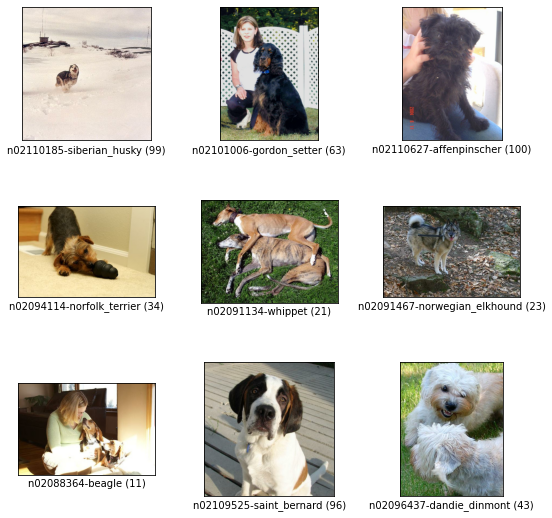

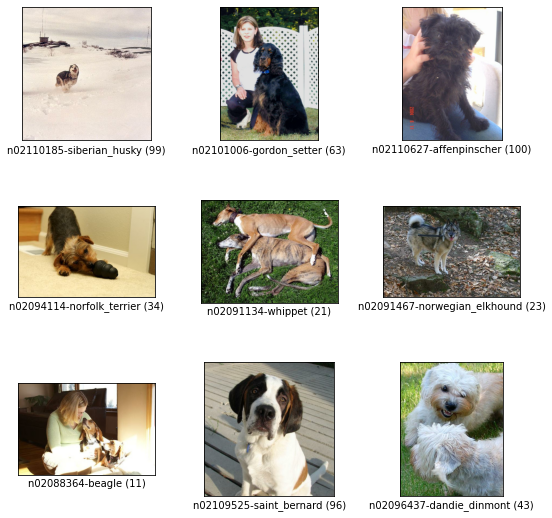

In [5]:
# 불러온 데이터 확인

tfds.show_examples(ds_train, ds_info)

## STEP 2. 데이터 전처리 함수 정의

In [6]:
# 전처리 : 이미지 레귤라이제이션 및 리사이즈

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label



In [7]:
# 데이터 Argmentation
# 좌우 반전
# 밝기 조절
# 클립

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2)  # 밝기 조절
    image = tf.clip_by_value(image, 0, 1)  # 클립해 줌
    return image, label



In [8]:
# 데이터셋(ds)을 가공하는 메인함수

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리(정규화) 함수 적용
        num_parallel_calls=2
    )
    # 트레인셋이냐 여부 및 augmentation 적용 여부냐 에 따라 
    # 트레인셋이고 aug 적용할 때만 aug함수 실행
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)

    # 셔플은 트레인셋 여부를 확인해서 트레인셋일때만 적용
    if not is_test:
        ds = ds.repeat()  # 반복해 주고
        ds = ds.shuffle(200)  # 셔플해줌
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 
    return ds



In [9]:
# make random augment function
# 이미지와 label을 받아서 Augmentation 처리 한 뒤 리턴해 줌
def augment2(image,label):
    # central_crop() 적용
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    # 리사이즈 적용
    image = tf.image.resize(image, [224, 224])
    return image, label

## STEP 3. 모델 구성 : with_aug vs. not_with_aug 비교 실험

* include_top은 마지막 fully connected layer를 포함할지 여부입
* 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있음
* 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문

In [10]:
# ResNet50 중 imagenet으로 사전 훈련된 모델 불러와 생성. resnet50으로 할당

# 클래스 개수 
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


94781440/94765736 [==============================] - 1s 0us/step


In [11]:
# Augmentation 적용한 데이터셋으로 학습시킬 ResNet 하나 더 생성 aug_resnet50으로 할당

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,  # 마지막 fully connected layer를 포함할지 여부
        # 미포함시켜 생성하면 필요할 때 목적에 맞게 수정된 fCL을 붙여서 쓸 수 있음
        # 가지고 온 이미지넷의 클래스와 우리의 목적에 필요한 클래스 수가 다르므로
        # 마지막에 붙이는 FCL의 뉴런의 개수도 달라짐

        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


## STEP 4. 데이터 구성

In [12]:
# 텐서플로우 데이터셋에서 불러온 데이터를 일단 train, test 셋으로 나눠주고
# 트레인 데이터셋에 Augmentation 적용, 미적용해 주기
# 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록
# 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# ds_train_no_aug_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_aug=False)
# ds_train_no_aug_mixup = apply_normalize_on_dataset_mixup(ds_train, with_aug=False)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


## STEP 4. 학습
* 이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행

In [13]:
# Augmentation 적용하지 않은 데이터셋 학습

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

EPOCH = 3

# resnet50 

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용 :: 요것만 다름
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 111s 121ms/step - loss: 2.2291 - accuracy: 0.4393 - val_loss: 3.3299 - val_accuracy: 0.2098
Epoch 2/3
750/750 [==============================] - 89s 119ms/step - loss: 0.6669 - accuracy: 0.8174 - val_loss: 1.1143 - val_accuracy: 0.6791
Epoch 3/3
750/750 [==============================] - 89s 119ms/step - loss: 0.2127 - accuracy: 0.9584 - val_loss: 0.9455 - val_accuracy: 0.7266


In [14]:
# Augmentation 적용한 데이터 

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용 :: 요것만 다름
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 129ms/step - loss: 2.2851 - accuracy: 0.4266 - val_loss: 3.0744 - val_accuracy: 0.2610
Epoch 2/3
750/750 [==============================] - 95s 127ms/step - loss: 0.9434 - accuracy: 0.7261 - val_loss: 1.3255 - val_accuracy: 0.6167
Epoch 3/3
750/750 [==============================] - 90s 120ms/step - loss: 0.5107 - accuracy: 0.8601 - val_loss: 1.0583 - val_accuracy: 0.6876


## STEP 5. 시각화

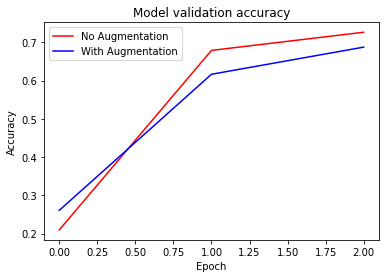

In [15]:
# 훈련 과정 시각화1

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'g')
# plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','No Aucumentation with Cutmix', 'No Augmentation with Mixup'], loc='upper left')

plt.show()

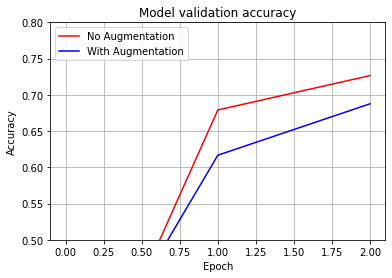

In [16]:
# 훈련 과정 시각화2 : 확대

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')  # 시각화 대상 지정 plt.plot(대상, 색상)
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'g') 
# plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')  # 그래프 제목
plt.ylabel('Accuracy')  # y축 제목
plt.xlabel('Epoch')  # x축 제목
plt.legend(['No Augmentation', 'With Augmentation','No Aucumentation with Cutmix', 'No Augmentation with Mixup'], loc='upper left') # 범례(종류(제목), 위치)

# 확대해서 보기
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.show()

## S3-1. 심화 : Cut Mix Augmentation
* 두 개의 이미지를 섞어주는데, 한쪽 이미지 일부를 잘라서 다른 한쪽에 갖다 붙이고
* 라벨링도 그에 맞게 변경해 주되, 면적 비율로 변경해 줌

### 1) 이미지 섞기

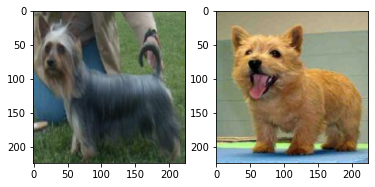

In [17]:
# 두 개의 이미지를 섞어주는 것부터 생각해봄
# 배치 내의 이미지를 두 개 골라서 섞어줌 => 이미지에서 잘라서 섞어주는 영역을 바운딩박스라고 함

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. take() 데이터열의 빠른 추출
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [18]:
# 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때,
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현해 봄
# width, height가 다르더라도 가변적으로 적용할 수 있도록 구현

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(126, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(79, shape=(), dtype=int32)


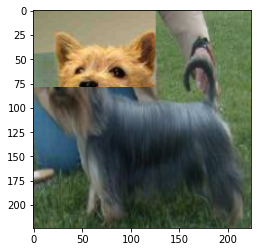

In [19]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합성하는 함수

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨링 섞기
* 이미지를 섞었다면 라벨도 이에 맞게 섞어줘야 함
* CutMix에서는 면적에 비례해서 라벨을 섞어줌
* 섞인 이미지의 전체 이미지 대비 비율을 계산해 두 가지 라벨의 비율로 더해줌

* 예를 들어, A클래스를 가진 원래 이미지 image_a와 B클래스를 가진 이미지 image_b를 섞을 때, image_a를 0.4만큼 섞었을 때 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 갖도록 해 줌.
* 이 때, 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫-인코딩 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식 사용함.

In [20]:
# 라벨 분리

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.19838169, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.80161834, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [32]:
# cutmix 처리 함수

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## STEP 3-2. 심화 : MixUp
* 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
* 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어 줌

### 1) Mixup 함수 구현

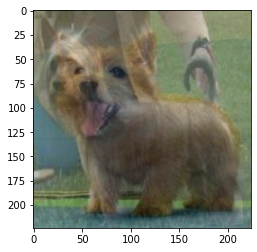

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.4083674 0.        0.        0.        0.        0.        0.
 0.5916326 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [21]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [23]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels



## Part II. 프로젝트 : Cutmix vs. Mixup 비교실험

## STEP 0. 환경설정

In [24]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## STEP 1. 데이터 전처리를 위한 함수 준비
### ! Caution
* CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()에서. batch() 함수 뒤에 CutMix가 오도록 만들어야함. 그 이유?
* => CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 함

In [34]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## STEP 2. 비교를 위한 모델 만들기

* Resnet50 without Aug
* Resnet50 with Aug
* Resnet50 without Aug & with CutMix
* Resnet50 without Aug & with Mixup

In [26]:
# imagenet으로 사전 훈련된 ResNet50 불러오기

num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [27]:
# Augmentation 적용한 데이터셋으로 학습시킬 ResNet 하나 더 생성

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [28]:
# imagenet으로 사전 훈련된 ResNet50 with Cutmix 불러오기

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [29]:
# imagenet으로 사전 훈련된 ResNet50 with Mixup 불러오기

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [35]:
# 데이터셋에 Augmentation 적용, 미적용

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


## STEP 3. 학습
* 주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!
* sparse_categorical_crossentropy()를 사용하지 못하는 이유?? 
* => 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [36]:
# 네 개 모델을 학습시키고 검증을 진행함

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

#EPOCH = 3

# ResNet50에 Augmentation을 적용하지 않은 데이터

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 126ms/step - loss: 2.2276 - accuracy: 0.4410 - val_loss: 3.4657 - val_accuracy: 0.1908
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 0.7683 - accuracy: 0.7889 - val_loss: 1.1216 - val_accuracy: 0.6697
Epoch 3/20
750/750 [==============================] - 94s 126ms/step - loss: 0.2668 - accuracy: 0.9392 - val_loss: 1.1644 - val_accuracy: 0.6655
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0878 - accuracy: 0.9887 - val_loss: 0.9270 - val_accuracy: 0.7348
Epoch 5/20
750/750 [==============================] - 97s 129ms/step - loss: 0.0283 - accuracy: 0.9987 - val_loss: 0.9077 - val_accuracy: 0.7430
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.9195 - val_accuracy: 0.7441
Epoch 7/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0114 - accuracy: 0.9998 - val_loss: 0.9539 - val_accuracy: 0.

In [37]:
# ResNet50에 Augmentation 적용한 데이터 

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 100s 121ms/step - loss: 2.2463 - accuracy: 0.4385 - val_loss: 3.1973 - val_accuracy: 0.2394
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.9464 - accuracy: 0.7253 - val_loss: 1.3436 - val_accuracy: 0.6235
Epoch 3/20
750/750 [==============================] - 90s 119ms/step - loss: 0.5415 - accuracy: 0.8472 - val_loss: 1.2068 - val_accuracy: 0.6610
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2756 - accuracy: 0.9364 - val_loss: 1.0436 - val_accuracy: 0.6996
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1762 - accuracy: 0.9618 - val_loss: 1.0474 - val_accuracy: 0.7070
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0934 - accuracy: 0.9843 - val_loss: 1.0334 - val_accuracy: 0.7147
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0575 - accuracy: 0.9920 - val_loss: 1.0029 - val_accuracy: 0.

In [38]:
# resnet50 with cutmix

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 102s 123ms/step - loss: 3.8393 - accuracy: 0.2101 - val_loss: 3.5587 - val_accuracy: 0.1835
Epoch 2/20
750/750 [==============================] - 96s 128ms/step - loss: 2.9421 - accuracy: 0.4321 - val_loss: 1.3684 - val_accuracy: 0.6217
Epoch 3/20
750/750 [==============================] - 96s 128ms/step - loss: 2.6591 - accuracy: 0.5228 - val_loss: 1.3145 - val_accuracy: 0.6361
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 2.4436 - accuracy: 0.5949 - val_loss: 1.1407 - val_accuracy: 0.6842
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2928 - accuracy: 0.6422 - val_loss: 1.2384 - val_accuracy: 0.6590
Epoch 6/20
750/750 [==============================] - 96s 127ms/step - loss: 2.1723 - accuracy: 0.6773 - val_loss: 1.3498 - val_accuracy: 0.6404
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 2.0643 - accuracy: 0.7150 - val_loss: 1.2773 - val_a

In [39]:
# resnet50 with mixup

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 101s 122ms/step - loss: 3.7352 - accuracy: 0.2364 - val_loss: 4.4502 - val_accuracy: 0.0851
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.8430 - accuracy: 0.4882 - val_loss: 1.5489 - val_accuracy: 0.5758
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.5760 - accuracy: 0.5889 - val_loss: 1.3173 - val_accuracy: 0.6351
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 2.3817 - accuracy: 0.6616 - val_loss: 1.2834 - val_accuracy: 0.6379
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 2.2478 - accuracy: 0.7070 - val_loss: 1.2100 - val_accuracy: 0.6646
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 2.1435 - accuracy: 0.7511 - val_loss: 1.2779 - val_accuracy: 0.6572
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 2.0802 - accuracy: 0.7698 - val_loss: 1.3124 - val_accuracy: 0.

## STEP 4. 시각화

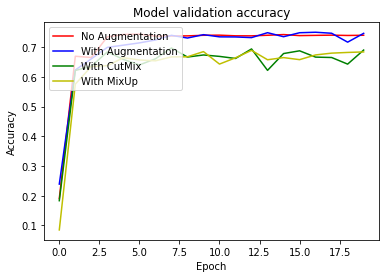

In [40]:
# 훈련 과정 시각화1

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()

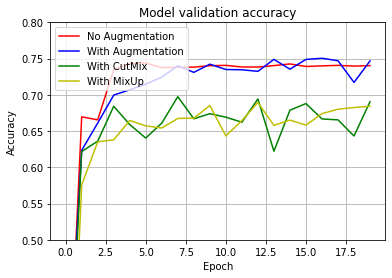

In [41]:
# 훈련 과정 시각화2 : 확대

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation',  'With CutMix', 'With MixUp'], loc='upper left')

# 확대해서 보기
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.show()

## STEP 5. 성능 비교
* ResNet50 without Augmentation
* ResNet50 with Augmentation
* Resnet50 with Cutmix & no Aug
* Resnet50 with Mixup & no Aug

In [44]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'no_aug': [
        round(np.array(history_resnet50_no_aug.history['loss']).mean(), 2),
        round(np.array(history_resnet50_no_aug.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_no_aug.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_no_aug.history['val_accuracy']).mean(), 2)
    ],
    'augmentation': [
        round(np.array(history_resnet50_aug.history['loss']).mean(), 2),
        round(np.array(history_resnet50_aug.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_aug.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_aug.history['val_accuracy']).mean(), 2)
    ],
    'cutmix': [
        round(np.array(history_resnet50_cutmix.history['loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_cutmix.history['val_accuracy']).mean(), 2)
    ],
    'mixup': [
        round(np.array(history_resnet50_mixup.history['loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['accuracy']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_loss']).mean(), 2),
        round(np.array(history_resnet50_mixup.history['val_accuracy']).mean(), 2)
    ],    
}

# 평가지표 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy'])
df_model_result

,no_aug,augmentation,cutmix,mixup
Train_Loss,0.17,0.23,2.06,2.09
Train_Accuracy,0.96,0.94,0.70,0.76
Val_Loss,1.12,1.16,1.43,1.46
Val_Accuracy,0.71,0.70,0.64,0.63


## [ 루브릭 ]
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
* CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴함.

2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
* Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함

3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
* 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석함



## [ 회고 ]
* 테스트에서 EPOCH는 Augmentation의 효과를 확인하는데 필요한 최소한으로 노드에서 추천한 대로 20으로 설정해 진행해 보았는데, 그 결과만으로 볼 때 기본 augmentation을 적용한 것이나, cutmix 또는 mixup 방식을 적용한 것 모두 기본 데이터셋에 비해 성능이 개선되지 않은 것으로 나타났다. 
* 특히 노드에서 심화방법으로 소개한 CutMix나 MixUp의 경우엔 기본 Augmentation에 비해서 낮은 성능을 나타냈다.
* 이유가 뭘까? EPOCH이 충분하지 않아서일까? CutMix나 MixUp을 제대로 활용하기 위한 방법이 무엇인지 학습이 필요한 것 같다.

## Reference. 
* 다수의 블로그 및 평가 결과에 대한 참조를 위해 PEBpung님의 깃헙을 참고하였음.